Finished simulation. The state recordings are available under `state_records`.
(6, 37500) y_train shape
(37500, 6) y_train shape
(37500, 800) x_train shape
Finished readout training. The readout weights are stored under the key: 0. Please use that key when calling `RNN.test()` or `RNN.predict()`.
AClassification performance on training data: 0.8712993077265935
Classification performance on test data: 0.8636854708575754 for eta =-2.0
wta score at 0.9856 for eta = -2.0
mean fire rate over all times: 0.03053119802865373 for eta =-2.0
Finished simulation. The state recordings are available under `state_records`.
mean Z of the qif network: 0.9383963258569946 and mean Z of the mean-field: 0.9296294029712296 for eta = -2.0
----------------------------------------------------------------------------------------------
Finished simulation. The state recordings are available under `state_records`.
(6, 37500) y_train shape
(37500, 6) y_train shape
(37500, 800) x_train shape
Finished readout traini

<ipython-input-3-3fee52bab303>:238: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/willi/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


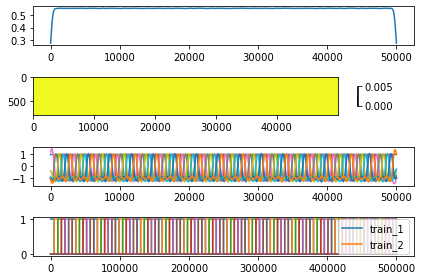

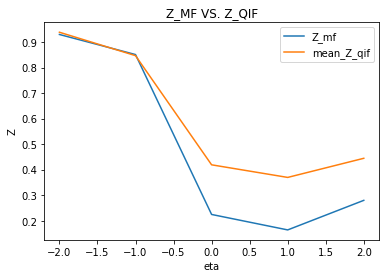

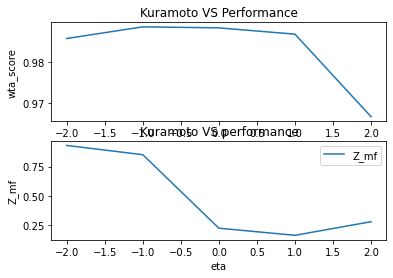

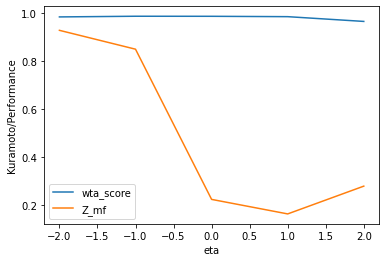

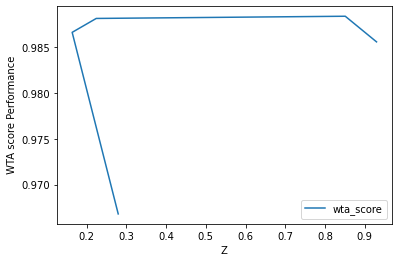

In [3]:
from rnn import QIFExpAddSyns
from rnn import mQIFExpAddSynsRNN
import numpy as np
import pickle
import math
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import sklearn

# STEP 0: Define simulation condition
#####################################

# parse worker indices from script arguments
idx_cond = 1

# STEP 1: Load pre-generated RNN parameters
###########################################

config = pickle.load(open("qif_input_config.pkl", 'rb'))

# connectivity matrix
C = config['C']

# input
inp = config['inp']

# input weights
W_in = config['W_in']

# simulation config
T = config['T']
dt = config['dt']
dts = config['dts']
cutoff = config['cutoff']
t = int((T - cutoff)/dts)
M = config['number_input_channels']

# target values
targets = config['targets']



# STEP 2: define remaining network parameters
#############################################

#### general parameters ####
N = C.shape[0]
m = W_in.shape[0]
n_folds = 5
ridge_alpha = 0.5*10e-3

#### qif parameters #####
Delta = 0.3
J = 10.0
D = 0.0
tau_a = 10.0
tau_s = 0.5

# adaptation strength #
alpha = 0.3

# etas #
n_etas = 5
etas = np.linspace(-2, 2, num=n_etas)


# STEP 3: Evaluate classification performance of RNN
####################################################

#### create dict to save data ####

data = {}
data["score"] = np.empty(n_etas)
data["wta_score"] = np.empty(n_etas)
data["r_qif"] = np.empty((n_etas, t))
data["v_qif"] = np.empty((n_etas, t))
data["r_mf"] = np.empty((n_etas, t))
data["v_mf"] = np.empty((n_etas, t))
data["Z_qif"] = np.empty((n_etas, t))
data["Z_mf"] = np.empty((n_etas))
data["eta"] = np.empty(n_etas)
data["etas"] = etas
data["Z_qif_mean"] = np.empty(n_etas)


#### simulation loop for n_etas ####

for j in range(n_etas):
    eta = etas[j]

    # setup QIF RNN
    qif_rnn = QIFExpAddSyns(C, eta, J, Delta=Delta, alpha=alpha, tau_s=tau_s, tau_a=tau_a, tau=1.0)

    # perform simulation
    results = qif_rnn.run(T, dt, dts, inp=inp, W_in=W_in, cutoff=cutoff, outputs=(np.arange(0, N), np.arange(3*N, 4*N)))
    v_qif = np.mean(results[0], axis=1)
    r_qif = np.mean(results[1], axis=1)
    X = results[1]
    # prepare training data
    buffer_val = 0
    for i in range(X.shape[1]):
        X[:, i] = gaussian_filter1d(X[:, i], 0.1 / dts, mode='constant', cval=buffer_val)
    for i in range(X.shape[1]):
        X[:, i] = gaussian_filter1d(X[:, i], 2.5 / dts, mode='constant', cval=buffer_val)
    r_qif2 = np.mean(X, axis=1)
    y = targets

    # split into test and training data
    split = int(np.round(X.shape[0]*0.75, decimals=0))
    X_train = X[:split, :]
    y_train = y[:, :split]
    X_test = X[split:, :]
    y_test = y[:, split:]
    print(y_train.shape, "y_train shape")
    y_train = np.transpose(y_train)
    y_test = np.transpose(y_test)

    print(y_train.shape, "y_train shape")
    print(X_train.shape, "x_train shape")


    # train RNN
    key, scores, coefs = qif_rnn.ridge_fit(X=X_train, y=y_train, alpha=ridge_alpha, k=0, fit_intercept=False, copy_X=True,
                                           solver='lsqr')
    #avg_coefs = np.mean(coefs, axis=0)
    #avg_coefs = avg_coefs.T
    #y_predict = X_test @ avg_coefs
    #print(y_predict.shape, "shape of y_predict")
    #print(avg_coefs.shape, "shape avg coeffs")
    #print(y_test.shape, "shape of y_test")
    score, _ = qif_rnn.test(X=X_test, y=y_test) # gives classification performance r^2 score
    y_predict = qif_rnn.predict(X=X, readout_key = None) # gives output of network every time step, will be plotted afterwards
    print(f"Classification performance on test data: {score} for eta ={eta}")

    # Winner takes it all classification; mean fire rate #
    y_predict_T = y_predict.T

    #X_wta_score = np.empty((1,t))
    wta_predict = y_predict_T.argmax(axis=0)
    wta_pred_test = wta_predict[split:]
    wta_target = y.argmax(axis=0)
    wta_targ_test = wta_target[split:]

    #X_wta_train = X_wta_score[:split]
    #x_wta_test = X_wta_score[split:]

    wta_score = np.mean(wta_pred_test == wta_targ_test)
    print(f"wta score at {wta_score} for eta = {eta}")
    r_qif_mean = (np.mean(r_qif2, axis= 0))
    v_qif_mean = (np.mean(v_qif, axis= 0))

    print(f"mean fire rate over all times: {r_qif_mean} for eta ={eta}")

    #### STEP 4 : setup mean-field model ####
    #########################################

    C_m = np.ones(shape=(1,))
    qif_mf = mQIFExpAddSynsRNN(C_m, eta, J, Delta=Delta, tau=1.0, alpha=alpha, tau_a=tau_a, tau_s=tau_s)
    results = qif_mf.run(T, dt, dts, cutoff=cutoff, outputs=([0], [1]))
    v_mf = np.squeeze(results[0])
    r_mf = np.squeeze(results[1])

    # Kuramoto Order Parameter Z #

    W_qif = np.empty((t), dtype=complex)
    for i in range(t):
        W_qif[i] = complex(math.pi*r_qif2[i],v_qif[i])
    Z_qif = np.empty((t), dtype=complex)
    for i in range(t):
        Z_qif[i] = np.abs((1 - W_qif[i].conjugate()) / (1 + W_qif[i].conjugate()))
        Z_qif = Z_qif.real

    Z_qif_mean = (np.mean(Z_qif, axis= 0))

    W_mf = np.empty((t), dtype=complex)
    for i in range(t):
        W_mf[i] = complex(math.pi * r_mf[i], v_mf[i])
    Z_mf = np.empty((t), dtype=complex)
    for i in range(t):
        Z_mf[i] = np.abs((1 - W_mf[i].conjugate()) / (1 + W_mf[i].conjugate()))
        Z_mf = Z_mf.real
    Z_mf = Z_mf[0]

    print(f"mean Z of the qif network: {Z_qif_mean} and mean Z of the mean-field: {Z_mf} for eta = {eta}")
    print('----------------------------------------------------------------------------------------------')

    #### store data ####

    data["eta"][j] = eta
    data["score"][j] = score
    data["wta_score"][j] = wta_score
    data["r_qif"][j,:] = r_qif2
    data["v_qif"][j,:] = v_qif
    data["r_mf"][j,:] = r_mf
    data["v_mf"][j,:] = v_mf
    data["etas"] = etas
    data["Z_qif"][j,:] = Z_qif
    data["Z_mf"][j] = Z_mf
    data["Z_qif_mean"][j] = Z_qif_mean

pickle.dump(data, open('old.data/qif_X_etas.pkl', 'wb'))

##################
#### plotting ####
##################

times = np.linspace(0, T, len(v_mf))
etas = data["etas"]
wta_score_all = data["wta_score"]
score_all = data["score"]
Z_qif_all = data["Z_qif"]
Z_mf_all = data["Z_mf"]
Z_qif_mean_all = data["Z_qif_mean"]

### input/output/target ###

fig, axes = plt.subplots(nrows=4)

ax1 = axes[0]
ax1.plot(np.mean(X, axis=1))

ax2 = axes[1]
im = ax2.imshow(X.T, aspect='auto', cmap="plasma", vmin=0, vmax=0.005)
plt.colorbar(im, ax=ax2, shrink=0.5)

ax3 = axes[2]
ax3.plot(y.T)
ax3.plot(y_predict)
plt.legend(['target', 'output'])

ax4 = axes[3]
start = int(cutoff/dt)
for i in range(M):
    ax4.plot(inp[i, start:])

plt.legend(['train_1', 'train_2'])

plt.tight_layout()


#### synchronicity check MF VS. QIF ####

fig, axes = plt.subplots()

axes.plot(etas, Z_mf_all)
axes.plot(etas, Z_qif_mean_all)
plt.legend(['Z_mf', 'mean_Z_qif'])
axes.set_title('Z_MF VS. Z_QIF')
axes.set_xlabel('eta')
axes.set_ylabel("Z")
plt.show()

#### Kuramoto vs Performance ####

fig2, axes = plt.subplots(2)
ax1 = axes[0]
ax1.plot(etas, wta_score_all)
plt.legend(['wta_score'])
ax1.set_title('Kuramoto VS Performance')
ax1.set_xlabel('eta')
ax1.set_ylabel("wta_score")

ax2 = axes[1]
ax2.plot(etas, Z_mf_all)
plt.legend(['Z_mf'])
ax2.set_title('Kuramoto VS performance')
ax2.set_xlabel('eta')
ax2.set_ylabel('Z_mf')
plt.tight_layout
plt.show()

plt.plot(etas, wta_score_all)
plt.plot(etas, Z_mf_all)
plt.legend (["wta_score", "Z_mf"])
plt.xlabel("eta")
plt.ylabel("Kuramoto/Performance")

plt.show()


plt.plot(Z_mf_all, wta_score_all)
plt.legend (["wta_score"])
plt.xlabel("Z")
plt.ylabel(" WTA score Performance")

plt.show()

plt.show()